## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

In [3]:
# 1) read the file and create a dataframe
file_name=r"C:\Users\utente\AppData\Local\Packages\CanonicalGroupLimited.Ubuntu18.04onWindows_79rhkp1fndgsc\LocalState\rootfs\home\beppe\data\data_000637.txt"
data=pd.read_csv(file_name)
df = pd.DataFrame(data, index = range(len(data)))

In [4]:
# 2) value of BX in ORBIT
x = df.max(axis=0)['BX_COUNTER'] + 1
print('Value of BX in an ORBIT:', x)

Value of BX in an ORBIT: 3564


In [5]:
# 3) time of data taking lasted
start = df[df['ORBIT_CNT'] == df.min(axis=0)['ORBIT_CNT']]
start = start[start['BX_COUNTER'] == start.min(axis=0)['BX_COUNTER']]
start = start[start['TDC_MEAS'] == start.min(axis=0)['TDC_MEAS']]

end = df[df['ORBIT_CNT'] == df.max(axis=0)['ORBIT_CNT']]
end = end[end['BX_COUNTER'] == end.max(axis=0)['BX_COUNTER']]
end = end[end['TDC_MEAS'] == end.max(axis=0)['TDC_MEAS']]

tot_time = ((end.iloc[0,3]*x + end.iloc[0,4] + end.iloc[0,5]*1/30) - (start.iloc[0,3]*x + start.iloc[0,4] + start.iloc[0,5]*1/30))*25
print('Total time to take data:',tot_time, 'ns')

Total time to take data: 980416253.3203125 ns


In [6]:
# 4) new column with absolute time (offset = minimum time)
df['TIME_IN_NS'] = df['TDC_MEAS']*25/30 + df['BX_COUNTER']*25 + df['ORBIT_CNT']*x*25 - (start.iloc[0,3]*x + start.iloc[0,4] + start.iloc[0,5]*1/30)*25
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_IN_NS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


In [7]:
# 5) random values for the column HEAD
df['HEAD'] = npr.randint(0,2,size=(len(df),1))
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_IN_NS
0,0,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,0,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,0,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,9.804161e+08
1310716,0,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


In [8]:
# 6) new dataframe with only the rows with HEAD = 1
df1 = pd.DataFrame(df[df['HEAD'] == 1])
df1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_IN_NS
1,1,0,124,3869200167,2374,27,8.125000e-01
3,1,0,64,3869200167,2558,19,4.594125e+03
6,1,0,61,3869200167,2772,14,9.940000e+03
7,1,0,139,3869200167,2776,0,1.002831e+04
8,1,0,62,3869200167,2774,21,9.995812e+03
...,...,...,...,...,...,...,...
1310712,1,1,35,3869211171,429,4,9.804078e+08
1310713,1,0,64,3869211171,758,18,9.804160e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


Text(0.5, 1.0, 'TDC_CHANNEL with FPGA = 1')

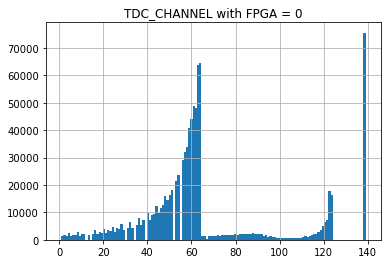

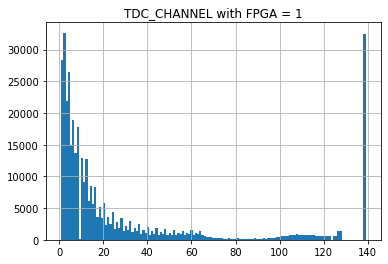

In [9]:
# 7) occupancy plots
fpga0 = df[df['FPGA'] == 0].hist('TDC_CHANNEL', bins = 139)
plt.title('TDC_CHANNEL with FPGA = 0')
fpga1 = df[df['FPGA'] == 1].hist('TDC_CHANNEL', bins = 139)
plt.title('TDC_CHANNEL with FPGA = 1')

In [10]:
# 8) find out the noisy channels
dfgr = df.groupby(['FPGA','TDC_CHANNEL']).count().sort_values(by= 'HEAD')
print('First three TDC channels with most counts:')
dfgr.tail(3)['HEAD']

First three TDC channels with most counts:


FPGA  TDC_CHANNEL
0     63             63724
      64             64581
      139            75617
Name: HEAD, dtype: int64

In [11]:
# 9) number of unique orbits
print('Number of unique orbits:', len(pd.unique(df['ORBIT_CNT'])))

# number of u.o. TDC_CHANNEL=139
print('Number of unique orbits (with at least one signal in ch.139):',len(pd.unique(df[df['TDC_CHANNEL'] == 139]['ORBIT_CNT'])))

Number of unique orbits: 11001
Number of unique orbits (with at least one signal in ch.139): 10976
